# Exemples d'utilisation de modèles simplifiés RC

<div style="text-align: right"> André Mounier </div>

---
Étude de l'effet sur les estimations de consommations annuelles

**Importation des modules**

In [1]:
import os 
import numpy as np
import tqdm
from datetime import date
import pandas as pd
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit

In [2]:
today = pd.Timestamp(date.today()).strftime('%Y%m%d')

output = 'output'
folder = '{}_RC_models'.format(today)
figs_folder = os.path.join(output, folder, 'figs')

if folder not in os.listdir(output):
    os.mkdir(os.path.join(output,folder))
if 'figs' not in os.listdir(os.path.join(output, folder)):
    os.mkdir(figs_folder)

In [3]:
draw_plots = False

## Définition de la température extérieure ($T_a$)

#### Valeurs historiques

Récupération de données historiques via l'API d'[Open-Météo](https://open-meteo.com) pour des [coordonnées](https://www.gps-longitude-latitude.net/longitude-latitude-coordonnees-gps-du-lieu) données.

In [4]:
def get_open_meteo_url(longitude, latitude, start_year, end_year, hourly_variables):
    """
    Récupération de l'url de l'API Open-Météo
    """
    if isinstance(hourly_variables, list):
        hourly_variables = ','.join(hourly_variables)
    url = 'https://archive-api.open-meteo.com/v1/archive?latitude={}&longitude={}&start_date={}-01-01&end_date={}-12-31&hourly={}&timezone=Europe%2FBerlin'.format(latitude,longitude,start_year,end_year,hourly_variables)
    return url


def open_meteo_historical_data(longitude, latitude, start_year, end_year, hourly_variables, force=False):
    """
    Ouverture des fichiers meteo
    """
    if isinstance(hourly_variables, list):
        hourly_variables_str = ','.join(hourly_variables)
    else:
        hourly_variables_str = hourly_variables
        
    save_path = os.path.join('data','Open-Meteo')
    save_name = '{}_{}_{}_{}_{}.csv'.format(hourly_variables_str, start_year, end_year, longitude, latitude)
    save_name_units = '{}_{}_{}_{}_{}_units.txt'.format(hourly_variables_str, start_year, end_year, longitude, latitude)

    if save_name not in os.listdir(save_path) or force:
        url = get_open_meteo_url(longitude, latitude, start_year, end_year, hourly_variables)
        response = requests.get(url)
        json_data = response.json()

        units = json_data.get('hourly_units')
        with open(os.path.join(save_path,save_name_units), 'w') as f:
            for col, unit in units.items():
                f.write('{} : {} \n'.format(col,unit))
        
        data = pd.DataFrame().from_dict(json_data.get('hourly'))
        data.to_csv(os.path.join(save_path,save_name), index=False)
        
    data = pd.read_csv(os.path.join(save_path,save_name))
    data = data.set_index('time')
    data.index = pd.to_datetime(data.index)
    return data

In [5]:
coordinates_dict = {'Paris':(2.352222, 48.856614),
                    'Marseille':(5.369780, 43.296482)
                   }

In [6]:
longitude, latitude = coordinates_dict.get('Paris')
start_year, end_year = 2000, 2020
hourly_variables = 'temperature_2m'

In [7]:
temperature_data = open_meteo_historical_data(longitude, latitude, start_year, end_year, hourly_variables)
temperature_data.head()

,temperature_2m
time,
2000-01-01 00:00:00,6.0
2000-01-01 01:00:00,6.1
2000-01-01 02:00:00,6.0
2000-01-01 03:00:00,6.0
2000-01-01 04:00:00,6.0


#### Approximations sinusoïdales

La température extérieure peut être vue comme constante sommée à une double sinusoïdale, d'une période journalière et annuelle :
$$
T_a(t) = \mu_y + \delta_y \sin\left(\frac{2\pi}{T_y}t + \phi_y \right) + \delta_d \sin\left(\frac{2\pi}{T_d}t + \phi_d \right)
$$
On utilise les données historiques pour obtenir les différents paramètres.
**C'est faux pour les variations journalières, à modifier**

In [8]:
month_day_hourly_data = pd.DataFrame(index=pd.date_range('2000-01-01', '2001-01-01', freq='h'))
month_day_hourly_data.index = month_day_hourly_data.index.strftime('%Y-%m-%d %H:%M:%S')

years = list(range(start_year, end_year+1))

for y in tqdm.tqdm(years):
    temperature_data_year = temperature_data[temperature_data.index.year==y]
    temperature_data_year = temperature_data_year.rename(columns={'temperature_2m':y})
    temperature_data_year.index = temperature_data_year.index.strftime('2000-%m-%d %H:%M:%S')
    
    month_day_hourly_data = month_day_hourly_data.join(temperature_data_year,how='left')
month_day_hourly_data.index = [pd.to_datetime('{}'.format(t)) for t in month_day_hourly_data.index]
month_day_hourly_data.index = month_day_hourly_data.index.tz_localize(tz='CET',ambiguous='NaT',nonexistent='NaT')
month_day_hourly_data = month_day_hourly_data[month_day_hourly_data.index.year==2000]
month_day_hourly_data.head()

100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 50.11it/s]


,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
2000-01-01 00:00:00+01:00,6.0,2.7,-1.1,3.5,1.5,9.0,3.9,12.2,4.5,-0.9,...,-0.5,12.0,8.2,7.2,0.5,6.7,-2.6,9.0,6.3,0.9
2000-01-01 01:00:00+01:00,6.1,3.1,-1.9,2.7,0.2,8.7,3.9,12.7,4.4,-1.4,...,-0.6,12.1,8.0,6.6,-0.1,6.7,-2.6,8.3,6.9,-0.1
2000-01-01 02:00:00+01:00,6.0,3.4,-2.3,2.7,-0.0,8.1,3.7,12.8,4.3,-2.0,...,-0.6,12.1,8.0,5.9,-0.7,6.8,-3.3,8.4,6.4,2.6
2000-01-01 03:00:00+01:00,6.0,3.9,-2.8,2.9,-0.2,7.6,3.2,12.7,4.3,-2.5,...,-0.7,12.1,8.0,5.5,-1.0,6.8,-3.5,8.0,6.7,2.1
2000-01-01 04:00:00+01:00,6.0,4.4,-3.2,3.0,0.1,6.9,2.9,12.2,4.1,-1.2,...,-0.8,12.0,8.0,5.2,-1.1,6.3,-3.6,8.0,6.5,1.9


En commençant par l'amplitude annuelle.

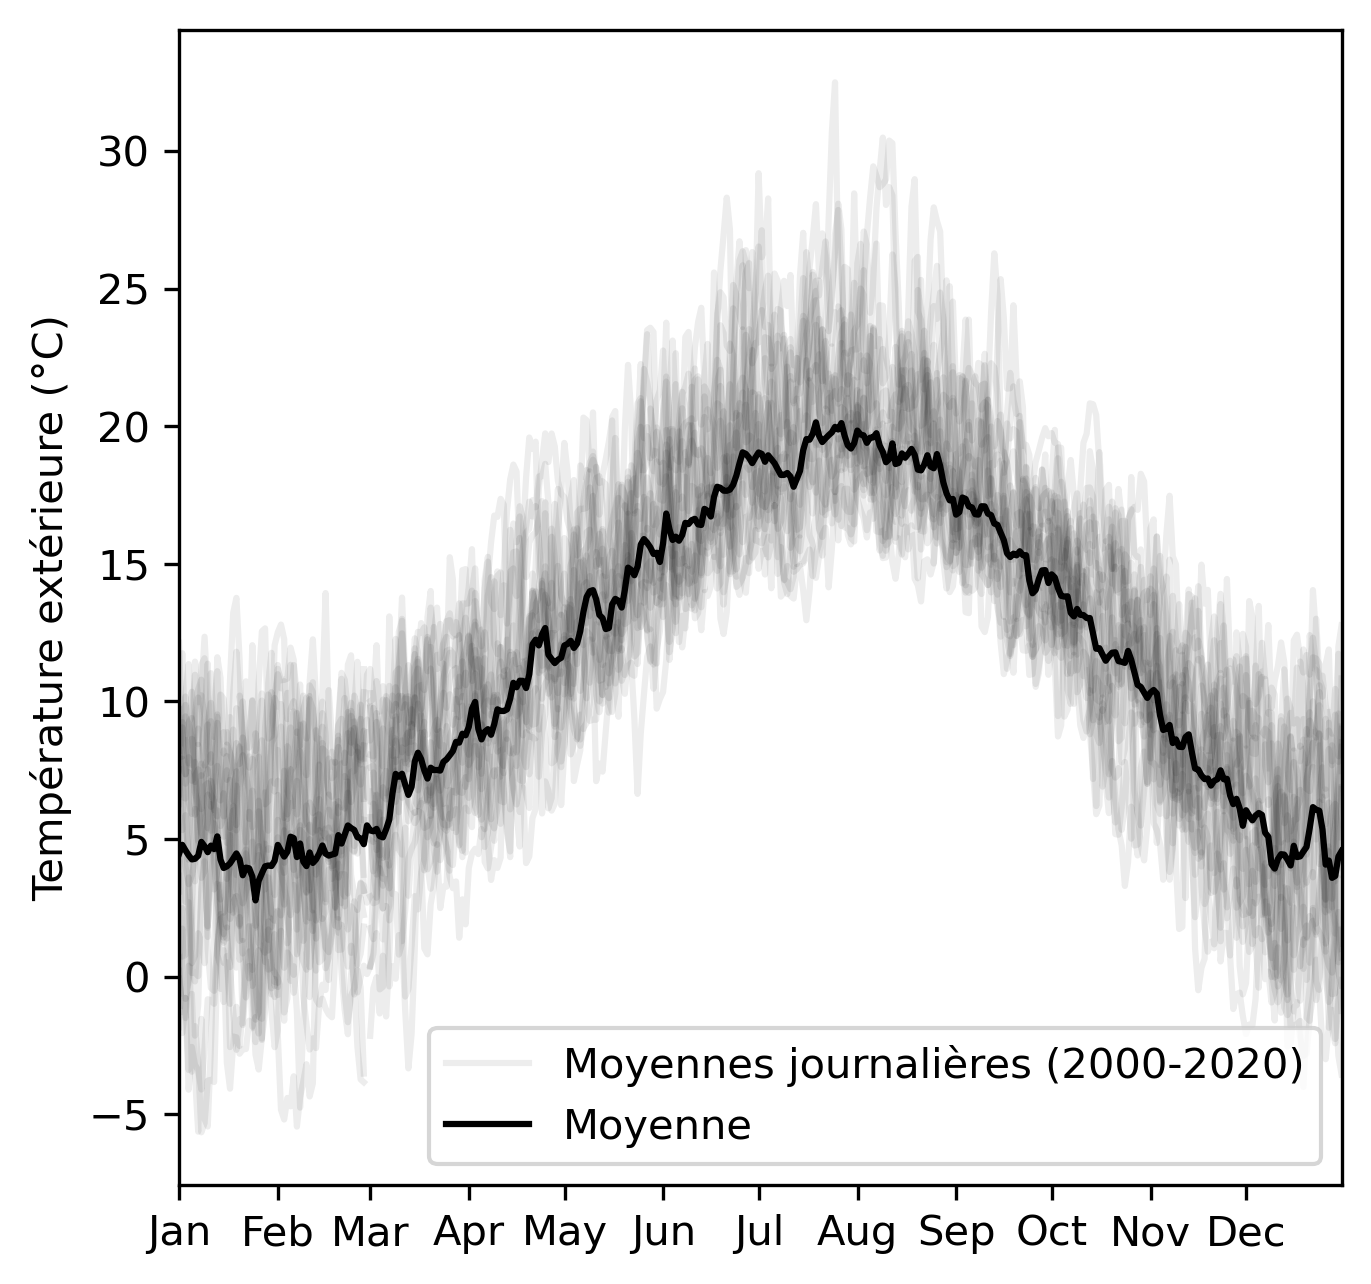

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 431.16it/s]


,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2014,2015,2016,2017,2018,2019,2020,model_annual_temperature,model_daily_temperature,model_temperature
2000-01-01 00:00:00+01:00,6.0,2.7,-1.1,3.5,1.5,9.0,3.9,12.2,4.5,-0.9,...,7.2,0.5,6.7,-2.6,9.0,6.3,0.9,4.540336,-0.402585,4.137751
2000-01-01 01:00:00+01:00,6.1,3.1,-1.9,2.7,0.2,8.7,3.9,12.7,4.4,-1.4,...,6.6,-0.1,6.7,-2.6,8.3,6.9,-0.1,4.538014,-0.591508,3.946506
2000-01-01 02:00:00+01:00,6.0,3.4,-2.3,2.7,-0.0,8.1,3.7,12.8,4.3,-2.0,...,5.9,-0.7,6.8,-3.3,8.4,6.4,2.6,4.535696,-0.753927,3.781769
2000-01-01 03:00:00+01:00,6.0,3.9,-2.8,2.9,-0.2,7.6,3.2,12.7,4.3,-2.5,...,5.5,-1.0,6.8,-3.5,8.0,6.7,2.1,4.533382,-0.879026,3.654356
2000-01-01 04:00:00+01:00,6.0,4.4,-3.2,3.0,0.1,6.9,2.9,12.2,4.1,-1.2,...,5.2,-1.1,6.3,-3.6,8.0,6.5,1.9,4.531072,-0.974770,3.556302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-12-31 19:00:00+01:00,1.9,-0.9,4.7,2.7,9.6,5.6,11.3,5.3,0.3,2.4,...,3.6,8.2,-2.6,11.2,8.1,0.4,2.8,4.496902,1.352797,5.849699
2000-12-31 20:00:00+01:00,2.0,-0.0,4.6,2.3,9.7,5.2,11.7,5.0,-0.7,2.1,...,1.7,7.7,-2.7,10.7,7.5,0.1,1.8,4.494656,0.892294,5.386949
2000-12-31 21:00:00+01:00,1.7,-1.2,4.7,1.7,9.5,4.5,12.1,5.0,-0.5,1.9,...,2.4,7.6,-2.6,10.3,7.3,-0.1,1.3,4.492414,0.470329,4.962742
2000-12-31 22:00:00+01:00,2.0,-1.2,4.6,1.1,9.4,4.3,12.3,4.8,-0.2,1.6,...,1.7,7.3,-2.6,9.9,6.8,-0.1,0.8,4.490176,0.113396,4.603572


In [28]:
if True:
    month_day_daily_data = month_day_hourly_data.groupby(pd.Grouper(freq='1D')).mean()
    
    fig,ax = plt.subplots(dpi=300,figsize=(5,5))
    for i,y in enumerate(years):
        label = None
        if i==0:
            label='Moyennes journalières ({}-{})'.format(years[0],years[-1])
        ax.plot(month_day_daily_data[y],color='k',alpha=0.07, label=label)
    ax.plot(month_day_daily_data.mean(axis=1),label='Moyenne',color='k')
    ax.legend()
    ax.set_xlim([pd.to_datetime('2000-01-01'), pd.to_datetime('2000-12-31')])
    ax.set_ylabel('Température extérieure (°C)')

    locator = mdates.AutoDateLocator()
    #formatter = mdates.ConciseDateFormatter(locator)
    formatter = mdates.DateFormatter('%b')
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    
    plt.savefig(os.path.join(figs_folder,'mean_daily_temperature_timeserie.png'),bbox_inches='tight')
    plt.show()

def annual_temperature_variation(t,mu_y=20, delta_y=10, phi_y=0):
    """
    Variations de températures annuelles au pas de temps horaire
    """
    t_hour = (t- t[0]).days*24 + (t- t[0]).seconds/3600
    T_hour = 24*365
    
    temperature = mu_y + delta_y * np.sin(2*np.pi*t_hour/T_hour+phi_y)
    return temperature

# on utilise les miyennes journalières et non pas horaires (réduction du bruit)
month_day_daily_data = month_day_hourly_data.groupby(pd.Grouper(freq='1D')).mean()

# moyenne des 20 années de données (2000-2020)
mean_daily = month_day_daily_data[years].mean(axis=1)

# moyenne glissante sur 10 jours pour lisser le fit de la sinusoide
mean_daily = mean_daily.rolling(10,center=True).mean()

# défintion des paramètres de la sinusoidale annuelle 
mu_y = (mean_daily.max() + mean_daily.min())/2
delta_y = mean_daily.max() - mu_y

shift_list = np.linspace(0,2*np.pi,100)
corr_list = []
for shift in tqdm.tqdm(shift_list):
    month_day_hourly_data['model_annual_temperature'] = annual_temperature_variation(month_day_hourly_data.index,mu_y,delta_y,phi_y=shift)

    month_day_daily_data = month_day_hourly_data.groupby(pd.Grouper(freq='1D')).mean()
    
    corr = r2_score(month_day_daily_data[years].mean(axis=1), month_day_daily_data['model_annual_temperature'])
    corr_list.append(corr)
phi_y = shift_list[corr_list.index(max(corr_list))]

# calcul des variations de températures annuelles
month_day_hourly_data['model_annual_temperature'] = annual_temperature_variation(month_day_hourly_data.index,mu_y,delta_y,phi_y=phi_y)

if False:
    fig,ax = plt.subplots(dpi=300,figsize=(5,5))
    ax.plot(shift_list,corr_list,label='Corrélation max : {:.1f} rad'.format(phi_y))
    ax.set_xlabel('Déphasage (rad)')
    ax.set_ylabel('Corrélation (R$^2$)')
    ax.legend()
    ax.set_ylim([0,1])
    plt.savefig(os.path.join(figs_folder,'mean_daily_temperature_sinewave_corr.png'),bbox_inches='tight')
    plt.show()

if False:
    month_day_daily_data = month_day_hourly_data.groupby(pd.Grouper(freq='1D')).mean()
    
    fig,ax = plt.subplots(dpi=300,figsize=(5,5))
    corr = r2_score(month_day_daily_data[years].mean(axis=1), month_day_daily_data['model_annual_temperature'])
    label= 'R$^2$ = {:.2f}'.format(corr)
    ax.plot(month_day_daily_data['model_annual_temperature'],month_day_daily_data[years].mean(axis=1),color='k',ls='',marker='o',alpha=0.05,label=label)
    ax.legend()
    ax.set_xlabel('Température extérieure modélisée (°C)')
    ax.set_ylabel('Température extérieure observée (°C)')
    diag = [0,month_day_hourly_data.max().max()]
    ax.plot(diag,diag, color='k')
    ax.set_ylim(diag)
    ax.set_xlim(diag)
    plt.savefig(os.path.join(figs_folder,'mean_daily_temperature_sinewave_versus.png'),bbox_inches='tight')
    plt.show()
    
if False:
    month_day_daily_data = month_day_hourly_data.groupby(pd.Grouper(freq='1D')).mean()
    
    fig,ax = plt.subplots(dpi=300,figsize=(5,5))
    ax.plot(month_day_daily_data[years].mean(axis=1),label='Observations (moyenne journalière)',color='k')
    ax.fill_between(month_day_daily_data[years].index, 
                    month_day_daily_data[years].mean(axis=1)+month_day_daily_data[years].std(axis=1),
                    month_day_daily_data[years].mean(axis=1)-month_day_daily_data[years].std(axis=1),color='lightgrey',zorder=-1)
    ax.plot(month_day_daily_data['model_annual_temperature'],label='Modélisation sinusoïdale',color='tab:blue')
    ax.legend()
    ax.set_xlim([pd.to_datetime('2000-01-01'), pd.to_datetime('2000-12-31')])
    ax.set_ylabel('Température extérieure (°C)')

    locator = mdates.AutoDateLocator()
    #formatter = mdates.ConciseDateFormatter(locator)
    formatter = mdates.DateFormatter('%b')
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    
    plt.savefig(os.path.join(figs_folder,'mean_daily_temperature_sinewave_timeserie.png'),bbox_inches='tight')
    plt.show()

month_day_hourly_data

Modélisation des variations intrajournalières. Pour éviter d'avoir trop de journées, j'utilise uniquement l'année 2020. 

In [10]:
prep_hour_hourly_data = pd.DataFrame(month_day_hourly_data[list(range(2000,2021))].mean(axis=1)).rename(columns={0:'mean_value'})
prep_hour_hourly_data['hour'] = prep_hour_hourly_data.index.hour
prep_hour_hourly_data['month'] = prep_hour_hourly_data.index.month
hour_hourly_data = prep_hour_hourly_data.groupby(['month','hour']).mean()
hour_hourly_data = hour_hourly_data.reset_index()

def get_second_order_daily_temperature_parameters(data):
    """
    Obtention des paramètres de modélisation des variations de températures journalières.
    """
    t = data.index.values
    res = np.zeros(t.shape)

    K_day = data.mean_value.max()
    K_night = data.mean_value.min()

    warming_period_start_hour = data.mean_value.idxmin()%24
    cooling_period_start_hour = data.mean_value.idxmax()%24
    tau = (cooling_period_start_hour - warming_period_start_hour)/4.5
    
    warming_period = (t%24>=warming_period_start_hour)&(t%24<=cooling_period_start_hour)
    cooling_period = (t%24>=cooling_period_start_hour)|(t%24<=warming_period_start_hour)
    intersection_period = (warming_period) & (cooling_period)
    
    def temperature_warming_period(t,Kmax,Kmin,tau):
        tp = t%24-warming_period_start_hour
        return Kmin + (Kmax-Kmin)*(1-np.exp(-tp/tau))*(1-np.exp(-tp/tau))

    def temperature_cooling_period(t,Kmax,Kmin,tau):
        tp = t%24-cooling_period_start_hour
        tp[tp < 0] += 24
        return Kmax - (Kmax-Kmin)*(1-np.exp(-tp/tau))*(1-np.exp(-tp/tau))

    p0_warming = (K_day,K_night,tau)
    popt_warming, _ = curve_fit(temperature_warming_period, t[warming_period], data.mean_value.values[warming_period], p0=p0_warming, method='lm')
    p0_cooling = (K_day,K_night,tau)
    popt_cooling, _ = curve_fit(temperature_cooling_period, t[cooling_period], data.mean_value.values[cooling_period], p0=p0_cooling, method='lm')
    
    #res[cooling_period] = temperature_cooling_period(t[cooling_period],*popt_cooling)
    #res[warming_period] = temperature_warming_period(t[warming_period],*popt_warming)
    #res[intersection_period] = (temperature_warming_period(t[intersection_period],*popt_warming) + temperature_cooling_period(t[intersection_period],*popt_cooling))/2

    parameters = {'warming':(warming_period_start_hour,*popt_warming),
                  'cooling':(cooling_period_start_hour,*popt_cooling),
                 }
    return parameters

daily_profile_parameters = dict()
for month in range(1,13):
    plot_hour_hourly_data = hour_hourly_data[hour_hourly_data.month==month].copy()
    plot_hour_hourly_data.mean_value = plot_hour_hourly_data.mean_value - plot_hour_hourly_data.mean_value.mean()
    more_hour = list(range(24,100))
    more_hour_df = pd.DataFrame().from_dict({'month':[month]*len(more_hour),'hour':more_hour, 'mean_value':[plot_hour_hourly_data[plot_hour_hourly_data.hour==h%24].mean_value.values[0] for h in more_hour]})
    plot_hour_hourly_data = pd.concat([plot_hour_hourly_data, more_hour_df])

    params = get_second_order_daily_temperature_parameters(plot_hour_hourly_data)
    daily_profile_parameters[month] = params

daily_profile_parameters.get(1)

{'warming': (np.int64(8),
  np.float64(5.927866407692974),
  np.float64(-1.5801417264466562),
  np.float64(5.96869185331835)),
 'cooling': (np.int64(16),
  np.float64(2.2453756824926776),
  np.float64(-1.2737468178314966),
  np.float64(3.506759327909116))}

In [11]:
def get_second_order_daily_temperature(t,parameters_dict):
    """
    Modélisation simplifiée des variations de températures journalières. 
    """
    def temperature_warming_period(t,warming_period_start_hour,Kmax,Kmin,tau):
        tp = t%24-warming_period_start_hour
        return Kmin + (Kmax-Kmin)*(1-np.exp(-tp/tau))*(1-np.exp(-tp/tau))

    def temperature_cooling_period(t,cooling_period_start_hour,Kmax,Kmin,tau):
        tp = t%24-cooling_period_start_hour
        if tp < 0:
            tp += 24
        return Kmax - (Kmax-Kmin)*(1-np.exp(-tp/tau))*(1-np.exp(-tp/tau))
        
    res = [np.nan]*len(t)
    for i,date in enumerate(t):
        date = pd.Timestamp(date)
        h = date.hour
        parameters = parameters_dict.get(date.month)
        param_warming = parameters.get('warming')
        param_cooling = parameters.get('cooling')

        warming_period = (h%24>=param_warming[0])&(h%24<=param_cooling[0])
        cooling_period = (h%24>=param_cooling[0])|(h%24<=param_warming[0])
        intersection_period = (warming_period) & (cooling_period)

        if intersection_period:
            res[i] = (temperature_warming_period(h,*param_warming) + temperature_cooling_period(h,*param_cooling))/2
        elif warming_period:
            res[i] = temperature_warming_period(h,*param_warming)
        else:
            res[i] = temperature_cooling_period(h,*param_cooling)
    return res

month_day_hourly_data['model_daily_temperature'] = get_second_order_daily_temperature(month_day_hourly_data.index.values,daily_profile_parameters)
month_day_hourly_data['model_temperature'] = month_day_hourly_data['model_annual_temperature'] + month_day_hourly_data['model_daily_temperature']
month_day_hourly_data.head()

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2014,2015,2016,2017,2018,2019,2020,model_annual_temperature,model_daily_temperature,model_temperature
2000-01-01 00:00:00+01:00,6.0,2.7,-1.1,3.5,1.5,9.0,3.9,12.2,4.5,-0.9,...,7.2,0.5,6.7,-2.6,9.0,6.3,0.9,4.540336,-0.402585,4.137751
2000-01-01 01:00:00+01:00,6.1,3.1,-1.9,2.7,0.2,8.7,3.9,12.7,4.4,-1.4,...,6.6,-0.1,6.7,-2.6,8.3,6.9,-0.1,4.538014,-0.591508,3.946506
2000-01-01 02:00:00+01:00,6.0,3.4,-2.3,2.7,-0.0,8.1,3.7,12.8,4.3,-2.0,...,5.9,-0.7,6.8,-3.3,8.4,6.4,2.6,4.535696,-0.753927,3.781769
2000-01-01 03:00:00+01:00,6.0,3.9,-2.8,2.9,-0.2,7.6,3.2,12.7,4.3,-2.5,...,5.5,-1.0,6.8,-3.5,8.0,6.7,2.1,4.533382,-0.879026,3.654356
2000-01-01 04:00:00+01:00,6.0,4.4,-3.2,3.0,0.1,6.9,2.9,12.2,4.1,-1.2,...,5.2,-1.1,6.3,-3.6,8.0,6.5,1.9,4.531072,-0.974770,3.556302


In [12]:
if False:
    days = 1
    intervals = 6
    
    fig,ax = plt.subplots(dpi=300,figsize=(5*days,5))
    month_season_dict = {1:'DJF',2:'DJF',3:'MAM',4:'MAM',5:'MAM',6:'JJA',7:'JJA',8:'JJA',9:'SON',10:'SON',11:'SON',12:'DJF'}
    season_color_dict = {'DJF':'tab:blue','MAM':'tab:green','JJA':'tab:red','SON':'tab:orange'}
    for month in range(1,13):
        plot_hour_hourly_data = hour_hourly_data[hour_hourly_data.month==month].copy()
        plot_hour_hourly_data.mean_value = plot_hour_hourly_data.mean_value - plot_hour_hourly_data.mean_value.mean()
        more_hour = list(range(24,100))
        more_hour_df = pd.DataFrame().from_dict({'month':[month]*len(more_hour),'hour':more_hour, 'mean_value':[plot_hour_hourly_data[plot_hour_hourly_data.hour==h%24].mean_value.values[0] for h in more_hour]})
        plot_hour_hourly_data = pd.concat([plot_hour_hourly_data, more_hour_df])
        if month in [1,4,7,10]:#list(range(1,13)):
            month_name = pd.to_datetime('2000-{}-01'.format(month)).strftime('%b')
            ax.plot(plot_hour_hourly_data.hour,plot_hour_hourly_data.mean_value,color=season_color_dict.get(month_season_dict.get(month)),ls=':')
            model = get_second_order_daily_temperature([pd.to_datetime('2000-{}-01 {}:00:00'.format(month, h%24)) for h in plot_hour_hourly_data.hour], daily_profile_parameters)
            corr = r2_score(plot_hour_hourly_data.mean_value, model)
            ax.plot(plot_hour_hourly_data.hour,model,color=season_color_dict.get(month_season_dict.get(month)),label='{} (R$^2$={:.2f})'.format(month_name, corr))
    ax.set_xlim([0,24*days])
    ax.set_xticks(list(range(0,24*days+1,intervals)), [x%24 if x!= 24 else x for x in list(range(0,24*days+1,intervals))])
    ax.legend()
    # ax.grid()
    ax.set_xlabel('Heure de la journée (h)')
    ax.set_ylabel('Écart à la température moyenne journalière (°C)')
    
    plt.savefig(os.path.join(figs_folder,'daily_temperature_2nd_order_fit_timeserie.png'),bbox_inches='tight')
    plt.show()

## Définition des apports solaires ($\Phi_s$)

#### Récupération des valeurs historiques

In [13]:
solar_variable = 'direct_radiation_instant' # 'direct_normal_irradiance_instant'
solar_data = open_meteo_historical_data(longitude, latitude, start_year, end_year, solar_variable)
solar_data.head()

,direct_radiation_instant
time,
2000-01-01 00:00:00,0.0
2000-01-01 01:00:00,0.0
2000-01-01 02:00:00,0.0
2000-01-01 03:00:00,0.0
2000-01-01 04:00:00,0.0


In [14]:
month_day_hourly_solar_data = pd.DataFrame(index=pd.date_range('2000-01-01', '2001-01-01', freq='h'))
month_day_hourly_solar_data.index = month_day_hourly_solar_data.index.strftime('%Y-%m-%d %H:%M:%S')

years = list(range(start_year, end_year+1))

for y in tqdm.tqdm(years):
    solar_data_year = solar_data[solar_data.index.year==y]
    solar_data_year = solar_data_year.rename(columns={solar_variable:y})
    solar_data_year.index = solar_data_year.index.strftime('2000-%m-%d %H:%M:%S')
    
    month_day_hourly_solar_data = month_day_hourly_solar_data.join(solar_data_year,how='left')
month_day_hourly_solar_data.index = [pd.to_datetime('{}'.format(t)) for t in month_day_hourly_solar_data.index]
month_day_hourly_solar_data.index = month_day_hourly_solar_data.index.tz_localize(tz='CET',ambiguous='NaT',nonexistent='NaT')
month_day_hourly_solar_data = month_day_hourly_solar_data[month_day_hourly_solar_data.index.year==2000]
month_day_hourly_solar_data

100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 51.45it/s]


,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
2000-01-01 00:00:00+01:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-01-01 01:00:00+01:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-01-01 02:00:00+01:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-01-01 03:00:00+01:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-01-01 04:00:00+01:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-12-31 19:00:00+01:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-12-31 20:00:00+01:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-12-31 21:00:00+01:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-12-31 22:00:00+01:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


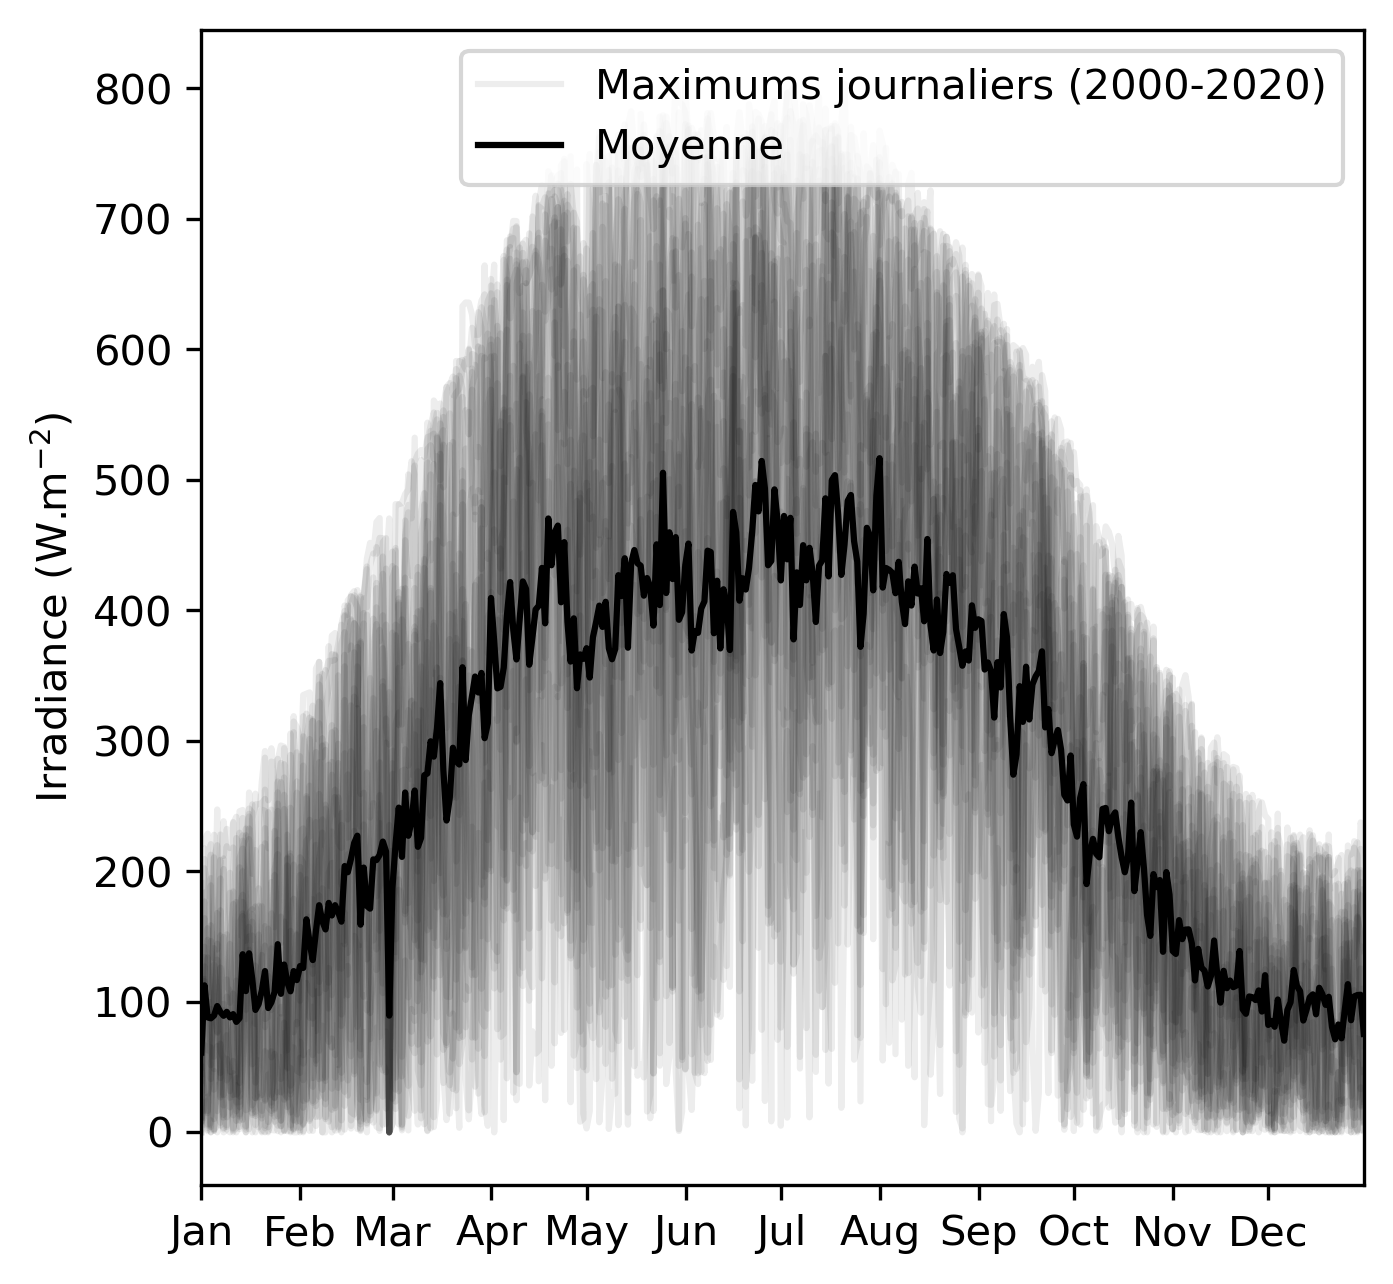

In [26]:
if True:
    month_day_daily_solar_data = month_day_hourly_solar_data.groupby(pd.Grouper(freq='1D')).max()
    
    fig,ax = plt.subplots(dpi=300,figsize=(5,5))
    for i,y in enumerate(years):
        label = None
        if i==0:
            label='Maximums journaliers ({}-{})'.format(years[0],years[-1])
        ax.plot(month_day_daily_solar_data[y],color='k',alpha=0.07, label=label)
    ax.plot(month_day_daily_solar_data.mean(axis=1),label='Moyenne',color='k')
    ax.legend()
    ax.set_xlim([pd.to_datetime('2000-01-01'), pd.to_datetime('2000-12-31')])
    ax.set_ylabel('Irradiance (W.m$^{-2}$)')

    locator = mdates.AutoDateLocator()
    #formatter = mdates.ConciseDateFormatter(locator)
    formatter = mdates.DateFormatter('%b')
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    
    plt.savefig(os.path.join(figs_folder,'max_daily_solar_irradiance_timeserie.png'),bbox_inches='tight')
    plt.show()

Modélisation de l'irradiance solaire à partir des équations astronomiques, incluses dans le module pysolar

In [16]:
from pysolar.solar import get_azimuth, get_altitude

month_day_hourly_solar_data['altitude'] = [get_altitude(latitude, longitude, d) if d is not pd.NaT else np.nan for d in month_day_hourly_solar_data.index]
month_day_hourly_solar_data['solar_zenith_angle'] = 90-month_day_hourly_solar_data.altitude
month_day_hourly_solar_data['model_irradiance'] = 1361*np.cos(np.deg2rad(month_day_hourly_solar_data.solar_zenith_angle))
month_day_hourly_solar_data[month_day_hourly_solar_data.model_irradiance < 0] = 0

In [17]:
#hour_hourly_solar_data = pd.DataFrame(month_day_hourly_solar_data[list(range(2000,2021))].mean(axis=1)).rename(columns={0:'mean_value'})
month_day_hourly_solar_data['hour'] = month_day_hourly_solar_data.index.hour
month_day_hourly_solar_data['day'] = month_day_hourly_solar_data.index.day
month_day_hourly_solar_data['month'] = month_day_hourly_solar_data.index.month

solar_correcter_dict = dict()
for year in range(2000,2021):
    for month in range(1,13):
        hour_hourly_solar_data = month_day_hourly_solar_data[month_day_hourly_solar_data.month==month].copy()
        hour_hourly_solar_data = hour_hourly_solar_data.groupby(by='hour').mean().reset_index()
        
        mean = hour_hourly_solar_data[[year]].mean(axis=1)
        model = hour_hourly_solar_data.model_irradiance
        correcter = model.max()/mean.max()
        model = model/correcter
        corr = r2_score(mean, model)
    
        solar_correcter_dict[pd.to_datetime('{}-{}-01'.format(year,month))] = correcter
    
if False:
    fig,ax = plt.subplots(dpi=300,figsize=(5*days,5))
    month_season_dict = {1:'DJF',2:'DJF',3:'MAM',4:'MAM',5:'MAM',6:'JJA',7:'JJA',8:'JJA',9:'SON',10:'SON',11:'SON',12:'DJF'}
    season_color_dict = {'DJF':'tab:blue','MAM':'tab:green','JJA':'tab:red','SON':'tab:orange'}
    for month in range(1,13):
        plot_hour_hourly_data = month_day_hourly_solar_data[month_day_hourly_solar_data.month==month].copy()
        plot_hour_hourly_data = plot_hour_hourly_data.groupby(by='hour').mean().reset_index()
        
        mean = plot_hour_hourly_data[list(range(2000,2021))].mean(axis=1)
        model = plot_hour_hourly_data.model_irradiance
        correcter = model.max()/mean.max()
        model = model/correcter
        corr = r2_score(mean, model)
        
        if month in [1,4,7,10]:#list(range(1,13)):,
            month_name = pd.to_datetime('2000-{}-01'.format(month)).strftime('%b')
            ax.plot(plot_hour_hourly_data.hour, mean ,color=season_color_dict.get(month_season_dict.get(month)),ls=':')
            ax.plot(plot_hour_hourly_data.hour,model,color=season_color_dict.get(month_season_dict.get(month)),label='{} (R$^2$={:.2f})'.format(month_name, corr))
    ax.set_xlim([0,24*days])
    ax.set_xticks(list(range(0,24*days+1,intervals)), [x%24 if x!= 24 else x for x in list(range(0,24*days+1,intervals))])
    ax.legend()
    # ax.grid()
    ax.set_xlabel('Heure de la journée (h)')
    ax.set_ylabel('Irradiation solaire (W.m$^{-2}$)')
    
    plt.savefig(os.path.join(figs_folder,'daily_solar_irradiance_timeserie.png'),bbox_inches='tight')
    plt.show()

solar_correcter_df = pd.DataFrame().from_dict({'date':list(solar_correcter_dict.keys()),'correcter':list(solar_correcter_dict.values())}).set_index('date')
solar_correcter_df['month'] = solar_correcter_df.index.month
solar_month_correcter = solar_correcter_df.groupby(by='month').agg(['mean','std']).rename(columns={'mean':'mean_value','std':'std_value'})
solar_month_correcter.columns = solar_month_correcter.columns.droplevel(0)

#popt, _ = curve_fit(lambda x,A,Phi,B: B+A*np.sin(2*np.pi/12*x+Phi), solar_correcter_df.month, solar_correcter_df.correcter, p0=(3,3,3))
#solar_month_correcter['smooth_correcter'] = [popt[2]+popt[0]*np.sin(2*np.pi/12*m+popt[1]) for m in solar_month_correcter.index]

deg = 0
poly_coefs = np.polyfit(solar_month_correcter.index, solar_month_correcter.mean_value, deg=deg)
solar_month_correcter['smooth_correcter'] = [sum([poly_coefs[i]*m**(deg-i) for i in range(deg+1)]) for m in solar_month_correcter.index]

smooth_solar_correcter_dict = {k:v for k,v in zip(solar_month_correcter.index, solar_month_correcter.smooth_correcter)}

if False:
    fig,ax = plt.subplots(dpi=300, figsize=(5,5))
    ax.errorbar(solar_month_correcter.index, solar_month_correcter.mean_value,yerr=solar_month_correcter.std_value,label='Corrections brutes',color='k',ls='',marker='o',capsize=2)
    ax.plot(solar_month_correcter.index, solar_month_correcter.smooth_correcter)
    #ax.plot(list(range(1,13)), [a*x**2+b*x+c for x in range(1,13)], label='Corrections lissées', color='tab:blue')
    ax.set_ylabel('Facteur correctif (sans unité)')
    ax.set_xlim([0.9,12.1])
    #ax.set_xlabel("Mois de l'année")
    ax.legend()
    plt.savefig(os.path.join(figs_folder,'daily_solar_irradiance_facteur_correctif.png'),bbox_inches='tight')
    plt.show()

smooth_solar_correcter_dict

{1: 3.8635229771252853,
 2: 3.8635229771252853,
 3: 3.8635229771252853,
 4: 3.8635229771252853,
 5: 3.8635229771252853,
 6: 3.8635229771252853,
 7: 3.8635229771252853,
 8: 3.8635229771252853,
 9: 3.8635229771252853,
 10: 3.8635229771252853,
 11: 3.8635229771252853,
 12: 3.8635229771252853}

In [18]:
month_day_hourly_solar_data['model_irradiance_corrected'] = [i/smooth_solar_correcter_dict.get(m) for i,m in zip(month_day_hourly_solar_data.model_irradiance, month_day_hourly_solar_data.index.month)]

if False:
    month_day_daily_solar_data = month_day_hourly_solar_data.groupby(pd.Grouper(freq='1D')).mean()
    
    fig,ax = plt.subplots(dpi=300,figsize=(5,5))
    # for i,y in enumerate(years):
    #     label = None
    #     if i==0:
    #         label='Moyennes journalières ({}-{})'.format(years[0],years[-1])
    #     ax.plot(month_day_daily_solar_data[y],color='k',alpha=0.07, label=label)
    mean_plot = month_day_daily_solar_data[list(range(2000,2021))].mean(axis=1)
    std_plot = month_day_daily_solar_data[list(range(2000,2021))].std(axis=1)
    ax.fill_between(mean_plot.index, mean_plot+std_plot, mean_plot-std_plot,color='lightgrey')
    ax.plot(month_day_daily_solar_data[list(range(2000,2021))].mean(axis=1),label='Moyenne',color='k')
    ax.plot(month_day_daily_solar_data.model_irradiance_corrected,label='Modélisation',color='tab:blue')
    ax.legend()
    ax.set_xlim([pd.to_datetime('2000-01-01'), pd.to_datetime('2000-12-31')])
    ax.set_ylabel('Irradiance (W.m$^{-2}$)')
    myFmt = mdates.DateFormatter('%b')
    ax.xaxis.set_major_formatter(myFmt)
    
    plt.savefig(os.path.join(figs_folder,'mean_modelled_daily_solar_irradiance_timeserie.png'),bbox_inches='tight')
    plt.show()

## Résolution des modèles RC

### Modèle 1 : R1C1

Initialisation du tableau

In [130]:
X_R1C1 = pd.DataFrame(index=pd.date_range('2000-01-01', '2001-01-01', freq='h'))
X_R1C1.index = X_R1C1.index.tz_localize(tz='CET',ambiguous='NaT',nonexistent='NaT')
X_R1C1 = X_R1C1[X_R1C1.index.year==2000]

Définition des constantes

In [197]:
R = 5e-3 # K/W # à rafiner etc

Phi_i = 400 # W # apports internes
Aw = 4 # m2 # surface vitrée par logement
T_i = 21 #°C

X_R1C1['C'] = [C]*len(X_R1C1)
X_R1C1['R'] = [R]*len(X_R1C1)
X_R1C1['Phi_i'] = [Phi_i]*len(X_R1C1)
X_R1C1['T_i'] = [T_i]*len(X_R1C1)

Ajout des variables météo

In [198]:
meteo_obs_year = 2020
X_R1C1['T_a'] = month_day_hourly_data[meteo_obs_year]
X_R1C1['Phi_s'] = month_day_hourly_solar_data[meteo_obs_year]*Aw*0.4

#### Résolution

In [209]:
X_R1C1['Phi_e'] = -1/X_R1C1['R']*X_R1C1['T_a'] + 1/X_R1C1['R']*X_R1C1['T_i'] - X_R1C1['Phi_i'] - X_R1C1['Phi_s']

X_R1C1['Phi_e_warming'] = X_R1C1[X_R1C1.Phi_e > 0].Phi_e
X_R1C1['Phi_e_cooling'] = X_R1C1[X_R1C1.Phi_e < 0].Phi_e

X_R1C1['Phi_e_cooling'] = - X_R1C1['Phi_e_cooling']
X_R1C1 = X_R1C1.fillna(0)

monthly_consumptions_R1C1 = X_R1C1[['Phi_e_cooling','Phi_e_warming']].groupby(pd.Grouper(freq='ME')).sum()/1000
monthly_consumptions_R1C1.index = monthly_consumptions_R1C1.index.strftime('%B')
monthly_consumptions_R1C1

,Phi_e_cooling,Phi_e_warming
January,0.00000,1885.52352
February,0.04368,1426.96960
March,2.51440,1545.96560
April,184.61264,736.73376
May,255.55552,594.18352
June,344.40592,299.58896
July,566.22688,163.11312
August,734.34304,124.91024
September,377.21312,336.70688
October,3.80608,951.63392


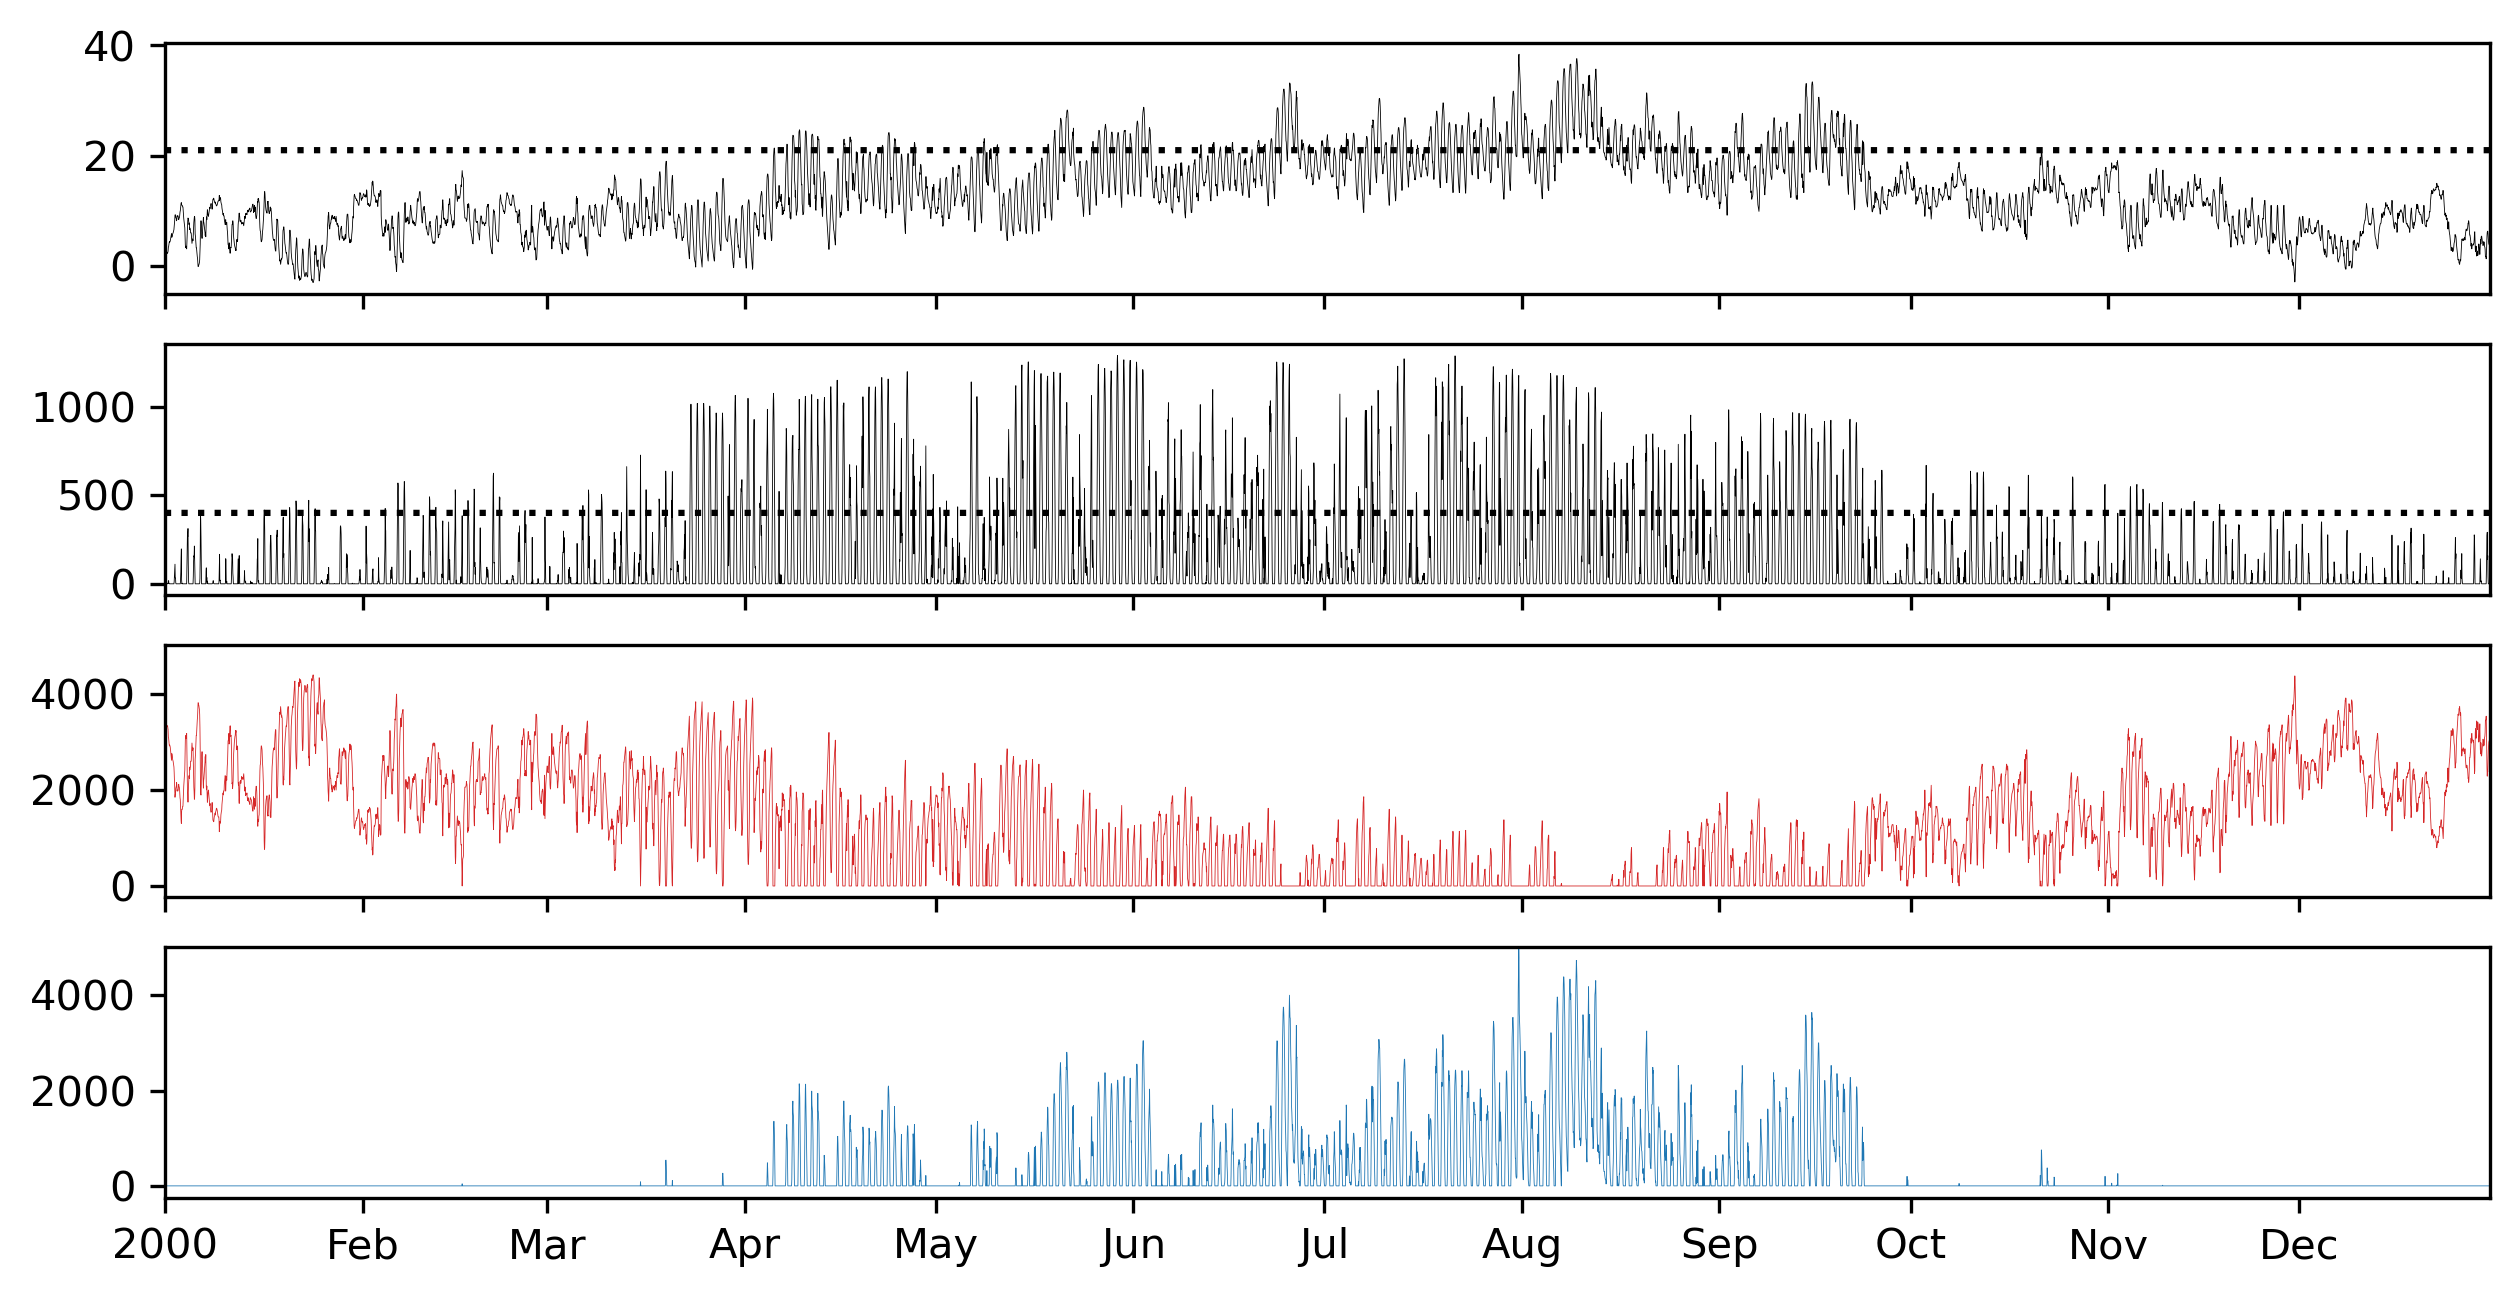

In [201]:
fig,axs = plt.subplots(4,1,dpi=300,figsize=(10,5),sharex=True)
axs = axs.flatten()

date_range = [pd.to_datetime('2000-01-01'), pd.to_datetime('2000-12-31')]

axs[0].plot(X_R1C1['T_a'],lw=0.2, label='External temperature (°C)',color='k')
axs[0].plot(X_R1C1['T_i'], label='Internal setpoint temperature (°C)',color='k',ls=':')

axs[1].plot(X_R1C1['Phi_s'],lw=0.2,color='k')
axs[1].plot(X_R1C1['Phi_i'],color='k',ls=':')

axs[2].plot(X_R1C1['Phi_e_warming'],lw=0.2,color='tab:red')
axs[2].set_ylim(top=max(abs(X_R1C1.Phi_e)))

axs[3].plot(X_R1C1['Phi_e_cooling'],lw=0.2,color='tab:blue')
axs[3].set_ylim(top=max(abs(X_R1C1.Phi_e)))

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
#formatter = mdates.DateFormatter('%b')
axs[0].xaxis.set_major_locator(locator)
axs[0].xaxis.set_major_formatter(formatter)

axs[0].set_xlim(date_range)
#axs[0].legend()

plt.show()

## Modèle 2 : R2C2

In [265]:
X_R2C2 = pd.DataFrame(index=pd.date_range('2000-01-01', '2001-01-01', freq='h'))
X_R2C2.index = X_R2C2.index.tz_localize(tz='CET',ambiguous='NaT',nonexistent='NaT')
X_R2C2 = X_R2C2[X_R2C2.index.year==2000]

R = 5e-3 # K/W # à rafiner etc
C = 1e-7 # J/K # idem

Phi_i = 400 # W # apports internes
Aw = 4 # m2 # surface vitrée par logement
T_i = 21 #°C

X_R2C2['C'] = [C]*len(X_R2C2)
X_R2C2['R'] = [R]*len(X_R2C2)
X_R2C2['Phi_i'] = [Phi_i]*len(X_R2C2)
X_R2C2['T_i'] = [T_i]*len(X_R2C2)
X_R2C2['Phi_e'] = [0]*len(X_R2C2)

meteo_obs_year = 2020
X_R2C2['T_a'] = month_day_hourly_data[meteo_obs_year]
X_R2C2['Phi_s'] = month_day_hourly_solar_data[meteo_obs_year]*Aw*0.4

#### Résolution

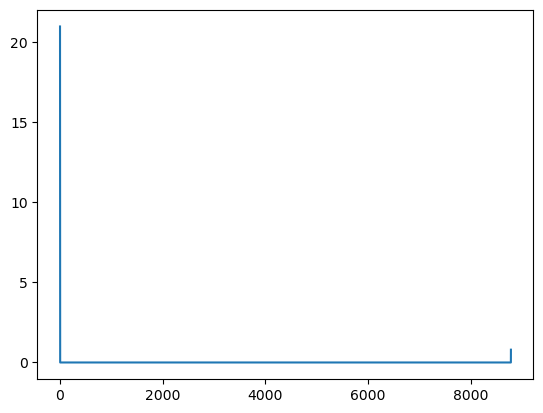

In [266]:
from scipy.linalg import expm 
from numpy.linalg import inv 

def dot3 (A,B,C): 
    return np.dot(A, np.dot(B,C)) 
    
def stack4 (A,B,C,D): 
    return np.vstack((np.hstack((A,B)),np.hstack((C,D))))

def RC_model_simulation(time, R1, R2, C1, C2, xe0): 
    # Matrices of the system in continuous form 
    Ac = np.array([[-1/(C1*R1) -1/(C1*R2), 1/(C1*R2)] , 
                   [1/(C2*R2), -1/(C2*R2)]]) 
    Bc = np.array([[1/(C1*R1),0],[0,1/C2]]) 
    
    # Matrices of the discretized state−space model 
    F = expm(Ac*delta_t) 
    G = dot3(inv(Ac),F-np.eye(2),Bc) 
    H = np.array([[0,1]]) # modifiée

    # Initialisation of the states 
    x = np.zeros((len(time_),2)) 
    x[0] = np.array((xe0,T_int[0])) 

    # Simulation for i in range (1 , len ( time )): 
    x[i] = np.dot(F, x[i-1]) + np.dot(G, u[i-1]) 

    # This function returns the second simulated state only 
    return np.dot(H, x.T).flatten()


time_ = np.array(X_R2C2.index)
T_int = np.array(X_R2C2['T_i'])
T_ext = np.array(X_R2C2['T_a'])
q = np.array(X_R2C2['Phi_e'])

delta_t = (time_[1]-time_[0]).total_seconds()/3600
u = np.vstack([T_ext,q]).T

test = RC_model_simulation(time_, R/2, R/2, C, C, T_int[0])
plt.plot(test)